In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# import tensorflow
from keras.models import load_model
from keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.Model import Sequential, load_model

In [45]:
dataset_path = "./static/dataset/Brazilian Tobacco Leaf Price Reference.csv"
dataframe = pd.read_csv(dataset_path)
dataframe

,Harvest_year,Company,Tobacco_Type,Class,R$_Kg
0,01/01/2018,Besuki Na Oogst,Gudang Garam,Jember,100674
1,02/01/2018,Besuki Na Oogst,Gudang Garam,Jember,142500
2,03/01/2018,Besuki Na Oogst,Gudang Garam,Jember,112557
3,04/01/2018,Besuki Na Oogst,Gudang Garam,Jember,96503
4,05/01/2018,Besuki Na Oogst,Gudang Garam,Jember,115845
...,...,...,...,...,...
1577,27/05/2024,Besuki Na Oogst,Gudang Garam,Jember,137920
1578,28/05/2024,Besuki Na Oogst,Gudang Garam,Jember,139829
1579,29/05/2024,Besuki Na Oogst,Gudang Garam,Jember,116125
1580,30/05/2024,Besuki Na Oogst,Gudang Garam,Jember,106244


## EDA

In [46]:
from datetime import datetime, timedelta

def konversi_tanggal(jumlah_hari):
    # Tanggal awal
    tanggal_awal = datetime(2024, 1, 1)

    # Kurangkan jumlah hari
    tanggal_hasil = tanggal_awal - timedelta(days=jumlah_hari)

    return tanggal_hasil

In [47]:
new_df = dataframe.iloc[:660]
new_df.insert(0, "tanggal", new_df.index)
new_df["tanggal"] = new_df["tanggal"].apply(konversi_tanggal)
new_df.drop(columns=["Harvest_year"], inplace=True)
new_df

C:\Users\lenovo\AppData\Local\Temp\ipykernel_31452\1852437804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["tanggal"] = new_df["tanggal"].apply(konversi_tanggal)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_31452\1852437804.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(columns=["Harvest_year"], inplace=True)


,tanggal,Company,Tobacco_Type,Class,R$_Kg
0,2024-01-01,Besuki Na Oogst,Gudang Garam,Jember,100674
1,2023-12-31,Besuki Na Oogst,Gudang Garam,Jember,142500
2,2023-12-30,Besuki Na Oogst,Gudang Garam,Jember,112557
3,2023-12-29,Besuki Na Oogst,Gudang Garam,Jember,96503
4,2023-12-28,Besuki Na Oogst,Gudang Garam,Jember,115845
...,...,...,...,...,...
655,2022-03-17,Besuki Na Oogst,Gudang Garam,Jember,143041
656,2022-03-16,Besuki Na Oogst,Gudang Garam,Jember,119715
657,2022-03-15,Besuki Na Oogst,Gudang Garam,Jember,128993
658,2022-03-14,Besuki Na Oogst,Gudang Garam,Jember,148764


In [48]:
def konversi_data(data):
    kurs_usd = 15000
    total_idr = data*kurs_usd
    
    return int(total_idr)

In [49]:
new_df = dataframe.iloc[:10]
new_df['R$_Kg'] = new_df['R$_Kg']#.apply(konversi_data)
new_df

C:\Users\lenovo\AppData\Local\Temp\ipykernel_31452\3184617469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['R$_Kg'] = new_df['R$_Kg']#.apply(konversi_data)


,Harvest_year,Company,Tobacco_Type,Class,R$_Kg
0,01/01/2018,Besuki Na Oogst,Gudang Garam,Jember,100674
1,02/01/2018,Besuki Na Oogst,Gudang Garam,Jember,142500
2,03/01/2018,Besuki Na Oogst,Gudang Garam,Jember,112557
3,04/01/2018,Besuki Na Oogst,Gudang Garam,Jember,96503
4,05/01/2018,Besuki Na Oogst,Gudang Garam,Jember,115845
5,06/01/2018,Besuki Na Oogst,Gudang Garam,Jember,129454
6,07/01/2018,Besuki Na Oogst,Gudang Garam,Jember,101453
7,08/01/2018,Besuki Na Oogst,Gudang Garam,Jember,130745
8,09/01/2018,Besuki Na Oogst,Gudang Garam,Jember,122481
9,10/01/2018,Besuki Na Oogst,Gudang Garam,Jember,146025


## MODELLING

In [55]:
# Fungsi untuk membuat dataset time series
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), 0])
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

In [56]:
# Preprocessing data
def preprocess_data(df):
    dataset = df['harga'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    return dataset, scaler

In [57]:
# Split data into train and test sets
def split_data(data):
    train_size = int(len(data) * 0.7)
    test_size = len(data) - train_size
    train, test = data[0:train_size,:], data[train_size:len(data),:]
    return train, test

In [59]:
# Build LSTM model
def build_model(time_steps, feature):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, feature)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [60]:
# Preprocess data
df = new_df.drop(columns=["Company", "Tobacco_Type", "Class"])
df = df.rename(columns={"R$_Kg": "harga"})
dataset, scaler = preprocess_data(df)

In [63]:
# Split data
train, test = split_data(dataset)

# Create dataset for LSTM
time_steps = 30
X_train, y_train = create_dataset(train, time_steps)
X_test, y_test = create_dataset(test, time_steps)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

IndexError: tuple index out of range

In [16]:
 # Build LSTM model
model = build_model(time_steps, 1)

# Train model
model.fit(X_train, y_train, epochs=100, batch_size=32)

ValueError: Expected input data to be non-empty.

In [17]:
# Evaluate model
train_loss = model.evaluate(X_train, y_train, verbose=0)
print('Train Loss:', train_loss)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', test_loss)

ValueError: Expected input data to be non-empty.

In [115]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

6/6 [==============================] - 0s 7ms/step


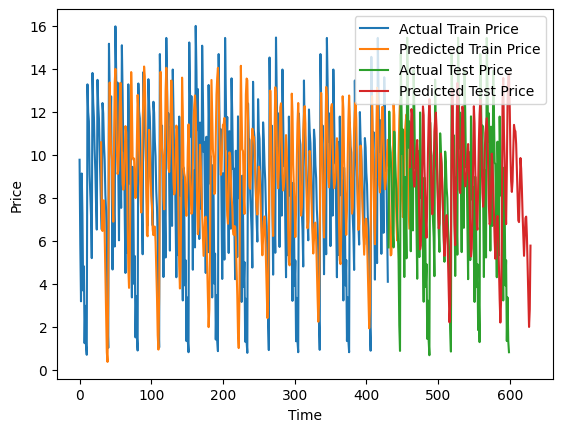

In [123]:
# Plotting
plt.plot(np.arange(0, len(y_train[0])), y_train[0], label='Actual Train Price')
plt.plot(np.arange(time_steps, len(train_predict)+time_steps), train_predict[:,0], label='Predicted Train Price')
plt.plot(np.arange(len(y_train[0]), len(y_train[0])+len(y_test[0])), y_test[0], label='Actual Test Price')
plt.plot(np.arange(len(y_train[0])+time_steps, len(y_train[0])+len(test_predict)+time_steps), test_predict[:,0], label='Predicted Test Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [20]:
# Save the model
model.save("static/model/lstm_model.h5")
print("Model saved successfully.")

Model saved successfully.


## TEST PREDIKSI UNTUK 7 HARI KEDEPAN

In [21]:
# Load Model
my_model = load_model("static/model/lstm_model.h5")

In [22]:
# Create input for prediction
last_30_days = dataset[:30]
X_input = np.reshape(last_30_days, (1, 30, 1))

ValueError: cannot reshape array of size 10 into shape (1,30,1)

In [175]:
# Predict for next 7 days
predicted_prices = []
for _ in range(7):
    next_day_prediction = model.predict(X_input)
    predicted_prices.append(next_day_prediction[0, 0])
    X_input = np.append(X_input[:,1:,:], next_day_prediction.reshape(1,1,1), axis=1)


1/1 [==============================] - 0s 36ms/step


In [176]:
# Inverse transform predictions
print(predicted_prices)
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

[0.4109317, 0.27892196, 0.26679745, 0.34850767, 0.3269497, 0.2606398, 0.20985527]


In [16]:
# Print predicted prices
print("Predicted prices for the next 7 days:")
for i in range(7):
    tanggal_prediksi = konversi_tanggal(i+1)
    print(f"Day {tanggal_prediksi} : ${predicted_prices[i][0]:.2f}")

Predicted prices for the next 7 days:


NameError: name 'predicted_prices' is not defined